In [3]:
from scipy.stats import ttest_ind, ttest_rel
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm

### Ancova Root

In [66]:
ungrazed_fruit = "59.77;60.98;14.73;19.28;34.25;35.53;87.73;63.21;24.25;64.34;52.92;32.35;53.61;54.86;64.81;73.24;80.64;18.89;75.49;46.73".split(";")
ungrazed_roots = "6.225;6.487;4.919;5.13;5.417;5.359;7.614;6.352;4.975;6.93;6.248;5.451;6.013;5.928;6.264;7.181;7.001;4.426;7.302;5.836".split(";")
grazed_fruit = "80.31;82.35;105.1;73.79;50.08;78.28;41.48;98.47;40.15;116.1;38.94;60.77;84.37;70.11;14.95;70.7;71.01;83.03;52.26;46.64".split(";")
grazed_roots = "8.988;8.975;9.844;8.508;7.354;8.643;7.916;9.351;7.066;10.25;6.958;8.001;9.039;8.91;6.106;7.691;8.515;8.53;8.158;7.382".split(";")

conv_lst = lambda x: np.array([float(el) for el in x])
ungrazed_fruit = conv_lst(ungrazed_fruit)
ungrazed_roots = conv_lst(ungrazed_roots)
grazed_fruit = conv_lst(grazed_fruit)
grazed_roots = conv_lst(grazed_roots)

In [67]:
roots = np.append(ungrazed_roots, grazed_roots)
fruits = np.append(ungrazed_fruit, grazed_fruit)
labels = np.array(["ungrazed"] * len(ungrazed_fruit) + ["grazed"] * len(grazed_fruit))

In [68]:
df = pd.DataFrame(data=[[l, f, r] for (l, f, r) in zip(labels, fruits, roots)], columns=["Label", "Fruit", "Root"])
df

,Label,Fruit,Root
0,ungrazed,59.77,6.225
1,ungrazed,60.98,6.487
2,ungrazed,14.73,4.919
3,ungrazed,19.28,5.130
4,ungrazed,34.25,5.417
5,ungrazed,35.53,5.359
6,ungrazed,87.73,7.614
7,ungrazed,63.21,6.352
8,ungrazed,24.25,4.975
9,ungrazed,64.34,6.930


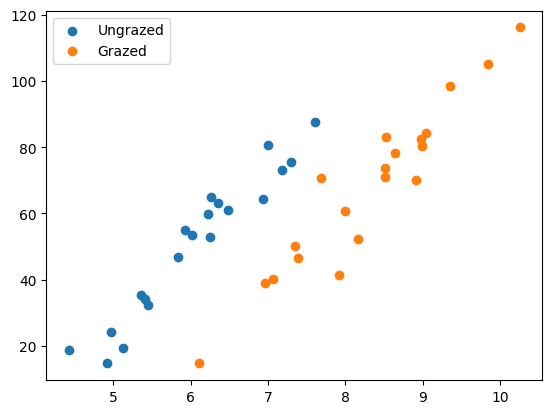

In [69]:
plt.scatter(ungrazed_roots, ungrazed_fruit, label="Ungrazed")
plt.scatter(grazed_roots, grazed_fruit, label="Grazed")
plt.legend()
plt.show()

<Axes: title={'center': 'Fruit'}, xlabel='[Label]'>

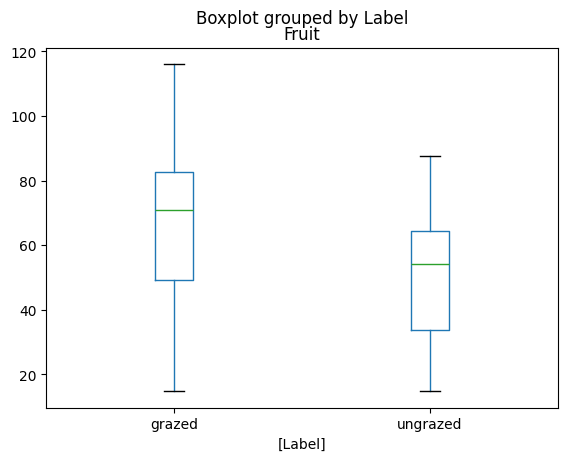

In [70]:
df.boxplot(column='Fruit', by=["Label"], grid=False)

In [71]:
formula = 'Fruit ~ Root * Label'
L = sm.OLS.from_formula(formula, data=df).fit()
anova = sm.stats.anova_lm(L, test='F', type=2).round(3)
print(anova)

              df     sum_sq    mean_sq        F  PR(>F)
Label        1.0   2911.801   2911.801   62.379   0.000
Root         1.0  19155.351  19155.351  410.362   0.000
Root:Label   1.0      4.640      4.640    0.099   0.754
Residual    36.0   1680.451     46.679      NaN     NaN


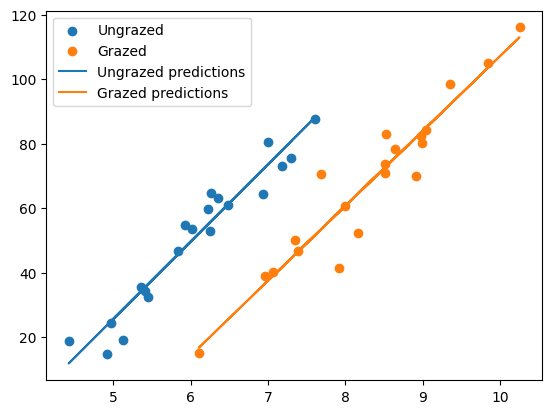

In [73]:
predictions = L.predict(df)
ungrazed_predictions = predictions[:20]
grazed_predictions = predictions[20:]

plt.scatter(ungrazed_roots, ungrazed_fruit, label="Ungrazed")
plt.scatter(grazed_roots, grazed_fruit, label="Grazed")
plt.plot(ungrazed_roots, ungrazed_predictions, label="Ungrazed predictions")
plt.plot(grazed_roots, grazed_predictions, label="Grazed predictions")
plt.legend()
plt.show()

### Building Sheets

In [130]:
df = pd.read_csv("sheets.txt", sep="\t")
df.rename(columns={"log.permeability": "lpa"}, inplace=True)
df = df.astype({'day': str, 'machine': str, 'lpa': float})

In [133]:
formula = 'lpa ~ machine + day'
L = sm.OLS.from_formula(formula, data=df).fit()
anova = sm.stats.anova_lm(L, test='F').round(5)
print(anova)

            df   sum_sq  mean_sq        F   PR(>F)
machine    2.0  0.00058  0.00029  0.02135  0.97888
day        8.0  0.20758  0.02595  1.91325  0.07147
Residual  70.0  0.94933  0.01356      NaN      NaN


In [135]:
pred_errors = []

for i in range(len(df)):
    train_data = df.drop(index=i)
    test_data = df.loc[i]
    formula = 'lpa ~ machine + day'
    model = sm.OLS.from_formula(formula, data=train_data).fit()
    prediction = model.predict(test_data)
    pred_errors.append(float((test_data["lpa"] - prediction)**2))

mse1 = np.mean(pred_errors)
print("Mean Squared Error:", mse1)

Mean Squared Error: 0.015692990204081624


In [144]:
pred_errors = []
machine_types = df['machine'].unique()

for i, machine_type in enumerate(machine_types):
    train_data = df[df['machine'] != machine_type]
    test_data = df[df['machine'] == machine_type]
    formula = 'lpa ~ day'
    model = sm.OLS.from_formula(formula, data=train_data).fit()
    prediction = model.predict(test_data)
    pred_errors.append(((test_data["lpa"].values - prediction.values) ** 2))

mse1 = np.mean(pred_errors)
print("Mean Squared Error:", mse1)

Mean Squared Error: 0.01550153497942387


In [145]:
pred_errors = []
machine_types = df['day'].unique()

for i, machine_type in enumerate(machine_types):
    train_data = df[df['day'] != machine_type]
    test_data = df[df['day'] == machine_type]
    formula = 'lpa ~ machine'
    model = sm.OLS.from_formula(formula, data=train_data).fit()
    prediction = model.predict(test_data)
    pred_errors.append(((test_data["lpa"].values - prediction.values) ** 2))

mse1 = np.mean(pred_errors)
print("Mean Squared Error:", mse1)

Mean Squared Error: 0.01576364801954732


In [153]:
pred_errors = []
machine_types = df['machine'].unique()
day_types = df['day'].unique()

for i, machine_type in enumerate(machine_types):
    for i, day_type in enumerate(day_types):
        train_data = df[(df['day'] != day_type) | (df['machine'] != machine_type)]
        test_data = df[(df['day'] == day_type) & (df['machine'] == machine_type)]
        prediction = len(test_data) * [np.mean(train_data["lpa"])]
        pred_errors.append(((test_data["lpa"] - prediction) ** 2))

mse1 = np.mean(pred_errors)
print("Mean Squared Error:", mse1)

Mean Squared Error: 0.01472760101784888


### COMPAS

In [4]:
df = pd.read_csv("compas_exercise_data.csv")
high_low = lambda x: "high" if x >= 5 else "low"
df["risk"] = df["compas_score"].apply(high_low)
df

,Unnamed: 0,id,name,sex,age,race,juv_fel_count,compas_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,risk
0,1,1,miguel hernandez,Male,69,Other,0,1,0,0,0,0,low
1,2,3,kevon dixon,Male,34,African-American,0,3,0,0,0,1,low
2,3,4,ed philo,Male,24,African-American,0,4,0,1,4,1,low
3,4,5,marcu brown,Male,23,African-American,0,8,1,0,1,0,high
4,5,6,bouthy pierrelouis,Male,43,Other,0,1,0,0,2,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,7210,10996,steven butler,Male,23,African-American,0,7,0,0,0,0,high
7210,7211,10997,malcolm simmons,Male,23,African-American,0,3,0,0,0,0,low
7211,7212,10999,winston gregory,Male,57,Other,0,1,0,0,0,0,low
7212,7213,11000,farrah jean,Female,33,African-American,0,2,0,0,3,0,low


In [31]:
df["race"].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [6]:
blacks = df[df["race"] == "African-American"]
whites = df[df["race"] == "Caucasian"]

In [7]:
blacks_high_risk_didnt_reoffend = blacks[(blacks["risk"] == "high") & (blacks["two_year_recid"] == 0)]
blacks_low_risk_did_reoffend = blacks[(blacks["risk"] == "low") & (blacks["two_year_recid"] == 1)]
whites_high_risk_didnt_reoffend = whites[(whites["risk"] == "high") & (whites["two_year_recid"] == 0)]
whites_low_risk_did_reoffend = whites[(whites["risk"] == "low") & (whites["two_year_recid"] == 1)]

In [8]:
blacks_high_risk = blacks[(blacks["risk"] == "high")]
blacks_low_risk = blacks[(blacks["risk"] == "low")]
whites_high_risk = whites[(whites["risk"] == "high")]
whites_low_risk = whites[(whites["risk"] == "low")]

In [12]:
ru = len(blacks_high_risk_didnt_reoffend) / len(blacks_high_risk) * 100
rd = len(blacks_low_risk_did_reoffend) / len(blacks_low_risk) * 100
lu = len(whites_high_risk_didnt_reoffend) / len(whites_high_risk) * 100
ld = len(whites_low_risk_did_reoffend) / len(whites_low_risk) * 100

In [17]:
print(str(lu) + " | " + str(ru) + "\n---------------------------------------\n" + str(ld) + " | " + str(rd))

40.866510538641684 | 37.02851885924563
---------------------------------------
28.812500000000004 | 34.95400788436268


In [35]:
L = sm.Logit.from_formula("two_year_recid ~  age + priors_count + juv_fel_count + juv_other_count + race", df).fit()
L.summary()

Optimization terminated successfully.
         Current function value: 0.614512
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         two_year_recid   No. Observations:                 7214
Model:                          Logit   Df Residuals:                     7204
Method:                           MLE   Df Model:                            9
Date:                Thu, 04 Jan 2024   Pseudo R-squ.:                  0.1072
Time:                        12:13:21   Log-Likelihood:                -4433.1
converged:                       True   LL-Null:                       -4965.2
Covariance Type:            nonrobust   LLR p-value:                2.497e-223
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8518      0.086      9.946      0.000       0.684       1.020
race[T.Asian]              -0.4238      0.412     -1.029      0.303      -1.231       0.383
race[T.Caucasian]          -0.0554      0.058     -0.954      0.340      -0.169       0.058
race[T.Hispanic]           -0.2368      0.095     -2.504      0.012      -0.422      -0.051
race[T.Native American]    -0.0254      0.522     -0.049      0.961      -1.049       0.999
race[T.Other]              -0.2342      0.119     -1.971      0.049      -0.467      -0.001
age                        -0.0448      0.003    -17.854      0.000      -0.050      -0.040
priors_count                0.1514      0.007     21.783      0.000       0.138       0.165
juv_fel_count               0.1808      0.083      2.175      0.030       0.018       0.344
juv_other_count             0.2002      0.062      3.232      0.001       0.079       0.322
===========================================================================================
"""

In [36]:
np.mean((L.predict(df) - df["two_year_recid"])**2) # with race

0.2120662441100862

In [39]:
L = sm.Logit.from_formula("two_year_recid ~  age + priors_count + juv_fel_count + juv_other_count + sex", df).fit()
np.mean((L.predict(df) - df["two_year_recid"])**2) # without race

Optimization terminated successfully.
         Current function value: 0.613798
         Iterations 6


0.2116874755668103

In [42]:
L = sm.Logit.from_formula("two_year_recid ~  age + priors_count + juv_fel_count + juv_other_count + sex + race", df).fit()
np.mean((L.predict(df) - df["two_year_recid"])**2) # without race

Optimization terminated successfully.
         Current function value: 0.613023
         Iterations 6


0.21140864817848862

In [41]:
L = sm.Logit.from_formula("two_year_recid ~  age + priors_count + juv_fel_count + juv_other_count", df).fit()
np.mean((L.predict(df) - df["two_year_recid"])**2) # without race

Optimization terminated successfully.
         Current function value: 0.615203
         Iterations 6


0.21230802950716082

In [55]:
correct = df[(df["two_year_recid"] == 1) & (df["risk"] == "high") | (df["two_year_recid"] == 0) & (df["risk"] == "low")]
len(correct) / len(df)

0.6537288605489326